### **LLMs as re-rankers**

#### **Finding the right McChicken**

This notebook compares single vector retriever with vector retrieval + reranking (using gpt 3.5 and gpt 4)

**Paper**: Is ChatGPT Good at Search? Investigating Large Language Models as Re-Ranking Agents - https://arxiv.org/abs/2304.09542  

**The test**: **How effective are LLMs are at re-ranking to identify target sentence to answer a question?**

I test out the use of LLMs as rerankers (from https://github.com/sunnweiwei/RankGPT) by injecting random sentences into a text document (1 target sentence and 8 distractors). Sentences are inserted at random positions in paul graham's essays, spaced at 256 words apart. The text documents are then split using langchain recursive character splitter with chunk size as 256. This ensures that each chunk doesn't have two sentences injected into them. The position of the chunk with the target sentence (target chunk) is then compared along with the time taken for retrieval. 

**Question:**
- "Was paul vegan?"

**Target sentence:**
- "Paul liked to eat McChicken burger."

**Example of distractors:**
- "Paul met McChicken at the library, where they discussed their favorite novels."  
- "While at the concert, Paul noticed Charlie enjoying a McChicken during the intermission, savoring each bite as he discussed the finer points of music."

**Retrieval Methods**:
- vanilla retrieval (single vector text-ada) of 20 chunks
- vanilla retrieval of 20 chunks + gpt 3.5 turbo 
- vanilla retrieval of 20 chunks + gpt 4 turbo 

**Test**:
- 50 runs of retrieval for each retrieval method and a comparison of target chunk position and retrieval (+ reranking) duration

In [34]:
import os
from dotenv import load_dotenv
load_dotenv()  
import warnings
import random
warnings.filterwarnings('ignore')
api_key = os.environ.get("OPENAI_API_KEY")


In [35]:
def load_text_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        return "The file was not found."
    except Exception as e:
        return f"An error occurred: {e}"


In [36]:
def convert_documents_to_query_structure(documents, query, method, duration):
    return {
        'query': query,
        'hits': [{'content': doc.page_content} for doc in documents],
        "method": method, # Add your custom key-value pair here
        "duration": duration
    }

**Functions to inject random sentence**

In [37]:
def find_injection_position(words, start_position):
    # Generate a list of potential positions (after a period) for injection
    potential_positions = [i + 1 for i in range(start_position, len(words)) if '.' in words[i]]

    # If there are suitable positions found, return a random one
    if potential_positions:
        # Ensure the selected position is at least 256 words away from the start_position
        filtered_positions = [pos for pos in potential_positions if pos > start_position + 256]
        if filtered_positions:
            return random.choice(filtered_positions)

    # If no suitable position is found or if they are too close, return the end of the text
    return len(words)


In [38]:
def inject_sentences(text, sentences_to_inject):
    # Split text into words
    original_words = text.split()

    # Shuffle the list of sentences to inject
    random.shuffle(sentences_to_inject)

    # The word count where the next sentence can be injected
    next_inject_position = 0

    # Iterate over the shuffled sentences to inject
    for sentence in sentences_to_inject:
        # Find a random position to inject this sentence
        # Ensure it's at least 256 words apart from the last injection
        position = find_injection_position(original_words, next_inject_position)

        # Prepare connecting words
        connecting_words = ["Furthermore, ", "Additionally, ", "On another note, ", "Moreover, "]

        # Choose a random connecting word
        connector = random.choice(connecting_words)

        # Inject the sentence
        original_words.insert(position, connector + sentence)

        # Update the next injection position
        next_inject_position = position + len(sentence.split()) + 256

    # Reassemble the text
    modified_text = ' '.join(original_words)
    return modified_text


**List of sentences to inject**

In [39]:
sentences_to_inject = sentences = [
    "Paul liked to eat McDonald's McChicken burger.",
    "Paul met McChicken at the library, where they discussed their favorite novels.",
    "In the park, Paul played chess with McChicken, who turned out to be a formidable opponent.",
    "During the community meeting, Paul and Burgers collaborated on a plan to beautify the neighborhood.",
    "McChicken and Paul volunteered together at the local animal shelter, taking care of abandoned pets.",
    "While at the concert, Paul noticed Burgers enjoying a McChicken during the intermission, savoring each bite as he discussed the finer points of music.",
    "During their morning jog, Paul saw McChicken energetically biting into a McChicken sandwich, talking about the balance of enjoying life while staying fit.",
    "In the pottery class, amidst the clay and creativity, Paul watched as McChicken took a thoughtful bite of a McChicken, reflecting on their shared passion for the arts.",
    "As they celebrated their first-place win in the science competition, Paul observed Burgers treating himself to a well-deserved McChicken, their success making it taste even better.",
    "At the museum, amidst a discussion of world history, Paul saw McChicken passionately explain the significance of ancient events, pausing only to enjoy bites of his McChicken sandwich."
]


**The Test**

In [40]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from rank_gpt import permutation_pipeline
import time

Inject given random sentences into text

In [41]:
def prep_text(file_path, sentences_to_inject):
    text = load_text_file(file_path)
    injected_text = inject_sentences(text, sentences_to_inject)
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=256,
        chunk_overlap=16,
        length_function=len,
        is_separator_regex=False,
    )
    texts = text_splitter.create_documents([injected_text])
    return texts

Perform vanilla retrieval or vanilla retrieval + reranking

In [42]:
def perform_retrieval(method, texts, api_key):
    embeddings = OpenAIEmbeddings()
    db = FAISS.from_documents(texts, embeddings)
    retriever = db.as_retriever(search_kwargs={"k": 10})
    query = "was paul vegan?"

    start_time = time.time()
    retrievals = retriever.get_relevant_documents(query)
    items = convert_documents_to_query_structure(retrievals, query, method, 0)

    if method != "vanilla":
        new_items = permutation_pipeline(items, rank_start=0, rank_end=19, model_name=method, api_key=api_key)
        new_items['duration'] = time.time() - start_time
        return new_items
    else:
        items['duration'] = time.time() - start_time
        return items

In [43]:
file_path = './docs/paul_graham_essay.txt'
documents = []
methods = ["vanilla", "gpt-3.5-turbo-1106", "gpt-4-1106-preview"]
n = 50

Run loop - n times for each method

In [44]:
for method in methods:
    for i in range(0, n):
        injected_texts = prep_text(file_path, sentences_to_inject)
        result = perform_retrieval(method, injected_texts, api_key)
        documents.append(result)


Extract df from results

In [45]:
import pandas as pd

def find_target_sentence_in_documents(documents, target_sentence):
    # Initialize an empty list to collect rows
    rows = []

    # Iterate through the documents
    for doc in documents:
        hits = doc['hits']
        method = doc.get('method')  # Use get() to avoid KeyError if 'method' does not exist
        duration = doc.get('duration')
        
        for index, item in enumerate(hits):
            content = item.get('content')  # Use get() to avoid KeyError if 'content' does not exist
            if target_sentence in content:
                # Create a dictionary for the row and add to the list
                rows.append({'position': index + 1, 'method': method, 'duration': duration})
                break  # Exit the loop once the target sentence is found

    # Create a DataFrame from the list of rows
    df = pd.DataFrame(rows)

    return df

# Example usage
target_sentence = "Paul liked to eat McDonald's McChicken burger."
df = find_target_sentence_in_documents(documents, target_sentence)

In [46]:
df.groupby('method').head(3)

,position,method,duration
0,2,vanilla,0.450947
1,4,vanilla,0.305946
2,5,vanilla,0.450533
43,1,gpt-3.5-turbo-1106,1.513926
44,1,gpt-3.5-turbo-1106,1.837910
45,4,gpt-3.5-turbo-1106,1.505612
89,1,gpt-4-1106-preview,1.735949
90,1,gpt-4-1106-preview,2.933766
91,1,gpt-4-1106-preview,2.536168


In [61]:
# Calculate the average position for each method
df_average = df.groupby('method')['position'].mean().reset_index(name='average_position (out of 10)')

# Sort the DataFrame in ascending order based on average positions
df_average_sorted = df_average.sort_values(by='average_position (out of 10)', ascending=True)

df_average_sorted

,method,average_position (out of 10)
1,gpt-4-1106-preview,1.090909
0,gpt-3.5-turbo-1106,1.847826
2,vanilla,3.000000


Total number of retrievals within the top 10 window (numbers vary because of randomisation)

In [70]:
# Count the number of times each method appears
method_counts = df['method'].value_counts()

# Convert the Series into a DataFrame
df_method_counts = method_counts.reset_index()
df_method_counts.columns = ['method', 'count']

# Display the new DataFrame
print(df_method_counts)

               method  count
0  gpt-3.5-turbo-1106     46
1  gpt-4-1106-preview     44
2             vanilla     43


Number of hits of target chunk at position 1 

In [67]:
# Filter the DataFrame for rows where position is 1
df_position_1 = df[df['position'] == 1]

# Count the number of occurrences of each method at position 1
position_1_counts = df_position_1['method'].value_counts()

# Display the counts
position_1_counts

method
gpt-4-1106-preview    41
gpt-3.5-turbo-1106    31
vanilla               11
Name: count, dtype: int64

**gpt-4 hits the target chunk 41 times out of 44 times!**

Visualing target chunk position

In [48]:
# Define colors for each method
color_map = {
    'vanilla': '#2ca02c',
    'gpt-3.5-turbo-1106': '#1f77b4',
    'gpt-4-1106-preview': '#d62728'
}

legend_names = {'vanilla': 'vanilla retrieval', 
                'gpt-3.5-turbo-1106': 'vanilla retrieval + gpt-3.5 reranking', 
                'gpt-4-1106-preview': 'vanilla retrieval + gpt-4 reranking'
}


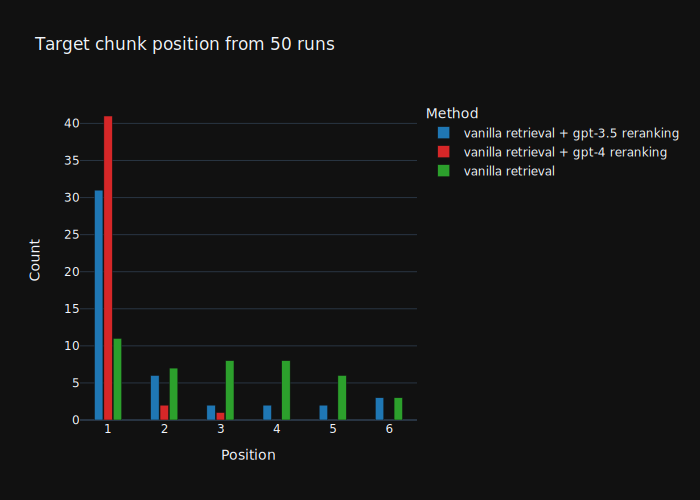

In [50]:
import pandas as pd
import plotly.express as px


# Prepare data for plotting
df_count = df.groupby(['position', 'method']).size().reset_index(name='count')

# Create a bar plot using Plotly
fig = px.bar(df_count, x='position', y='count', color='method', barmode='group',
             title='Target chunk position from 50 runs',
             color_discrete_map=color_map)

# Customize axis labels, layout, and apply dark theme
fig.update_xaxes(title_text='Position')
fig.update_yaxes(title_text='Count', tickformat='d')
fig.update_layout(
    template='plotly_dark',
    legend_title_text='Method',
    bargap=0.5,  # Smaller gap between bars of different x-coordinates
    bargroupgap=0.1  # Smaller gap within groups of bars
)

# Update the layout to show all x-axis labels and rotate them if necessary
fig.update_xaxes(
    tickmode='array',
    tickvals=df_count['position'],
    ticktext=df_count['position'],
    tickangle=0  # Rotate labels by -45 degrees, adjust the angle as needed
)

# Update legend names
for trace in fig.data:
    trace.name = legend_names.get(trace.name, trace.name)

# Show the plot
fig.show("svg")

Plot of average duration

In [57]:
# Calculate the average position for each method
df_avg_duration = df.groupby('method')['duration'].mean().reset_index(name='average_duration (s)')

# Sort the DataFrame in ascending order based on average positions
df_avgd_sorted = df_avg_duration.sort_values(by='average_duration (s)', ascending=True)

df_avgd_sorted

,method,average_duration (s)
2,vanilla,0.385295
0,gpt-3.5-turbo-1106,1.493956
1,gpt-4-1106-preview,2.760631


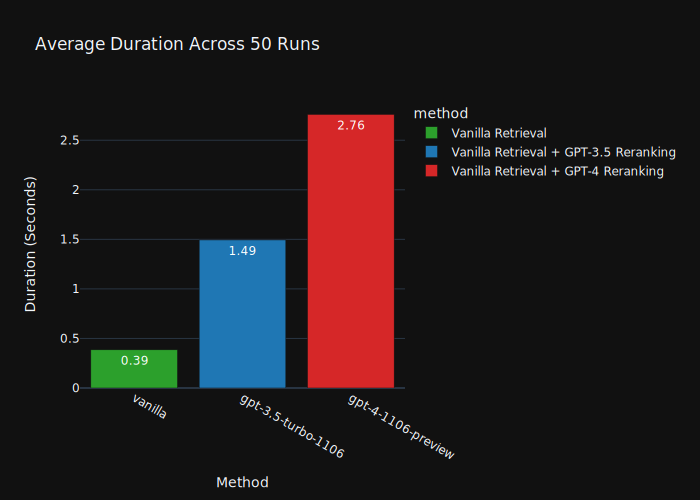

In [66]:
import pandas as pd
import plotly.express as px

# Create a bar plot for duration with specified colors
fig = px.bar(df_avgd_sorted, x='method', y='average_duration (s)', color='method',
             title='Average Duration Across 50 Runs',
             color_discrete_map=color_map,
             text='average_duration (s)')  # Add this line

# Customize the text inside bars
fig.update_traces(texttemplate='%{text:.2f}', textposition='inside')

# Customize axis labels and apply dark theme
fig.update_xaxes(title_text='Method')
fig.update_yaxes(title_text='Duration (Seconds)')
fig.update_layout(template='plotly_dark')

# Make the bars thinner
fig.update_traces(marker=dict(line=dict(width=0.5)))


for trace in fig.data:
    trace.name = legend_names.get(trace.name, trace.name)

# Show the plot
fig.show("svg")
